In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence
from torchtext.data import Field
from torch.utils.tensorboard import SummaryWriter
from torchsummaryX import summary

import warnings
warnings.filterwarnings("ignore")
from itertools import groupby
from jiwer import wer
import pandas as pd
import os
import matplotlib.pyplot as plt

from Core import cnn_rnn
from Core.dataset import PhoenixDataset, Phoenix_Full_TrackedHand


#-----------------------------load dataset--------------------------
TRG = Field(sequential=True, use_vocab=True,
            init_token=None, eos_token= None,
            lower=True, tokenize='spacy',
            tokenizer_language='de')


root = '/mnt/data/public/datasets'
csv_dir = os.path.join(root, 'phoenix2014-release/phoenix-2014-multisigner')
csv_dir = os.path.join(csv_dir, 'annotations/manual/train.corpus.csv')
csv_file = pd.read_csv(csv_dir)
tgt_sents = [csv_file.iloc[i, 0].lower().split('|')[3].split()
             for i in range(len(csv_file))]
TRG.build_vocab(tgt_sents, min_freq=1)
VocabSize = len(TRG.vocab)

def collate_full_trackedHand(batch):
    fullVideos = [item['fullVideo'] for item in batch]
    video_lens = torch.tensor([len(v) for v in fullVideos])
    fullVideos = pad_sequence(fullVideos, batch_first=True)
    trackedHandVideos = [item['trackedHandVideo'] for item in batch]
    trackedHandVideos = pad_sequence(trackedHandVideos, batch_first=True)
    annotations = [item['annotation'].split() for item in batch]
    annotation_lens = torch.tensor([len(anno) for anno in annotations])
    annotations = TRG.process(annotations)
    return {'fullVideos': fullVideos,
            'trackedHandVideos':trackedHandVideos,
            'annotations': annotations,
            'video_lens': video_lens,
            'annotation_lens': annotation_lens}

fullFrameSize = 224
trackedHandFrameSize = 112
BSZ = 2
interval = 4

fullTransform = transforms.Compose([
    transforms.RandomResizedCrop(fullFrameSize, (0.8,1)),
    transforms.ToTensor()])

trackedHandTransform = transforms.Compose([
    transforms.RandomResizedCrop(trackedHandFrameSize, (0.8,1)), 
    transforms.ToTensor()])

train_loader = DataLoader(
    Phoenix_Full_TrackedHand(
        root, mode='train', interval=interval, fullTransform=fullTransform,
        trackedHandTransform = trackedHandTransform),
    batch_size=BSZ, shuffle=True, num_workers=BSZ,
    collate_fn=collate_full_trackedHand, pin_memory=True)

dev_loader = DataLoader(
    Phoenix_Full_TrackedHand(
        root, mode='dev', interval = interval, fullTransform=fullTransform,
        trackedHandTransform = trackedHandTransform),
    batch_size=BSZ, shuffle=False, num_workers=BSZ,
    collate_fn=collate_full_trackedHand, pin_memory=True)

test_loader = DataLoader(
    Phoenix_Full_TrackedHand(
        root, mode='test', interval = interval, fullTransform=fullTransform,
        trackedHandTransform = trackedHandTransform),
    batch_size=BSZ, shuffle=False, num_workers=BSZ,
    collate_fn=collate_full_trackedHand, pin_memory=True)


# # 视频长度1/4？ dataset
# def collate_fn(batch):
#     videos = [item['video'] for item in batch]
#     video_lens = torch.tensor([len(v) for v in videos])
#     videos = pad_sequence(videos, batch_first=True)
#     annotations = [item['annotation'].split() for item in batch]
#     annotation_lens = torch.tensor([len(anno) for anno in annotations])
#     annotations = TRG.process(annotations)
#     return {'videos': videos,
#             'annotations': annotations,
#             'video_lens': video_lens,
#             'annotation_lens': annotation_lens}


# transform = transforms.Compose([
#     transforms.RandomResizedCrop(FrameSize),
#     transforms.ToTensor()])

# train_loader = DataLoader(
#     PhoenixDataset(root, mode='train', transform=transform),
#     batch_size=BatchSize, shuffle=True, num_workers=BatchSize,
#     collate_fn=collate_fn, pin_memory=True)

# val_loader = DataLoader(
#     PhoenixDataset(root, mode='dev', transform=transform),
#     batch_size=BatchSize, shuffle=False, num_workers=BatchSize,
#     collate_fn=collate_fn, pin_memory=True)

# test_loader = DataLoader(
#     PhoenixDataset(root, mode='test', transform=transform),
#     batch_size=BatchSize, shuffle=False, num_workers=BatchSize,
#     collate_fn=collate_fn, pin_memory=True)


#-----------------------------define train--------------------------
def train(net, train_loader, criterion, optimizer, epoch, writer):
    net.train()
    running_wer = 0.0
    running_loss = 0.0
    for batch_idx, batch in enumerate(train_loader):
        # ?
        fullVideos = batch['fullVideos'].cuda()
        trackedHandVideos = batch['trackedHandVideos'].cuda()
        targets = batch['annotations'].permute(1,0).contiguous().cuda()
        input_lens = batch['video_lens'].cuda()
        target_lens = batch['annotation_lens'].cuda()
        
        optimizer.zero_grad()
        outs = net(fullVideos, trackedHandVideos)
        loss = criterion(outs, targets, input_lens, target_lens)
        loss.backward()

        flag = False
        for name, param in net.named_parameters():
            if torch.isnan(param.grad).any():
                flag = True
                break
        if flag:
            print(batch_idx)
            continue
            
        optimizer.step()
        
        
        outs = outs.max(-1)[1].permute(1,0).contiguous().view(-1)
        # best ctc_decoder?
        outs = ' '.join([TRG.vocab.itos[k] for k, _ in groupby(outs) if k != VocabSize])
        targets = targets.view(-1)
        targets = ' '.join([TRG.vocab.itos[k] for k in targets])
        running_wer += wer(targets, outs, standardize=True)
        running_loss += loss.item()
        
        N = len(train_loader) // 10
        if batch_idx % N == N-1:
            writer.add_scalar('train wer',
                              running_wer/N,
                              epoch*len(train_loader)+batch_idx)
            writer.add_scalar('train loss',
                              running_loss/N,
                              epoch*len(train_loader)+batch_idx)
        
            running_wer = 0.0
            running_loss = 0.0    


#-----------------------------define dev--------------------------
def val(net, dev_loader, criterion, epoch, writer):
    net.eval()
    epoch_wer = 0.0
    epoch_loss = 0.0
    with torch.no_grad():
        for batch_idx, batch in enumerate(dev_loader):
            fullVideos = batch['fullVideos'].cuda()
            trackedHandVideos = batch['trackedHandVideos'].cuda()
            targets = batch['annotations'].permute(1,0).contiguous().cuda()
            input_lens = batch['video_lens'].cuda()
            target_lens = batch['annotation_lens'].cuda()
            
            outs = net(fullVideos, trackedHandVideos)
            loss = criterion(outs, targets, input_lens, target_lens)
            
            outs = outs.max(-1)[1].permute(1,0).contiguous().view(-1)
            outs = ' '.join([TRG.vocab.itos[k] for k, _ in groupby(outs) if k != VocabSize])
            targets = targets.view(-1)
            targets = ' '.join([TRG.vocab.itos[k] for k in targets])
            epoch_wer += wer(targets, outs, standardize=True)
            epoch_loss += loss.item()
            
            
        epoch_wer /= len(dev_loader)
        epoch_loss /= len(dev_loader)
        if writer:
            writer.add_scalar('dev wer', epoch_wer, epoch)
            writer.add_scalar('dev loss', epoch_loss, epoch)
          
    return epoch_loss, epoch_wer


#-----------------------------train dev test--------------------------
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
save_root = '/home/xieliang/Data/sign-language-recognition'
save_model = os.path.join(save_root, 'save/CNN_RNN_CTC1.pth')
save_log = os.path.join(save_root, 'log/CNN_RNN_CTC1')

nHID = 1024
nLAYER = 1
resume_training = False
if resume_training:
    save_dict = torch.load(save_model)
    start_epoch = save_dict['epoch']+1
    best_dev_wer = save_dict['best_dev_wer']
    net = save_dict['net'].cuda()
else:
    start_epoch = 0
    best_dev_wer = 2
    # ?
    net = cnn_rnn.CNN_RNN_Concat(VocabSize, nHID, nLAYER, dropout=0.5).cuda()

LR = 1e-4
WD = 1e-4
criterion = nn.CTCLoss(blank=VocabSize)
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [60, 100])
writer = SummaryWriter(save_log)

print(f'start training from epoch {start_epoch} with best dev wer {best_dev_wer}')
for epoch in range(start_epoch, 1000):
#     train(net, train_loader, criterion, optimizer, epoch, writer)
    dev_loss, dev_wer = val(net, dev_loader, criterion, epoch, writer)
    lr_scheduler.step()
    print(f'epoch:{epoch} | dev_loss:{dev_loss} | dev_wer:{dev_wer} | lr:{lr_scheduler.get_lr()}')

#     if dev_wer < best_dev_wer:
#         best_dev_wer = dev_wer
#         torch.save({'epoch': epoch, 'best_dev_wer': best_dev_wer,
#                     'net': net}, save_model)
#         print(f'model saved with best dev wer: {best_dev_wer} in epoch {epoch}')



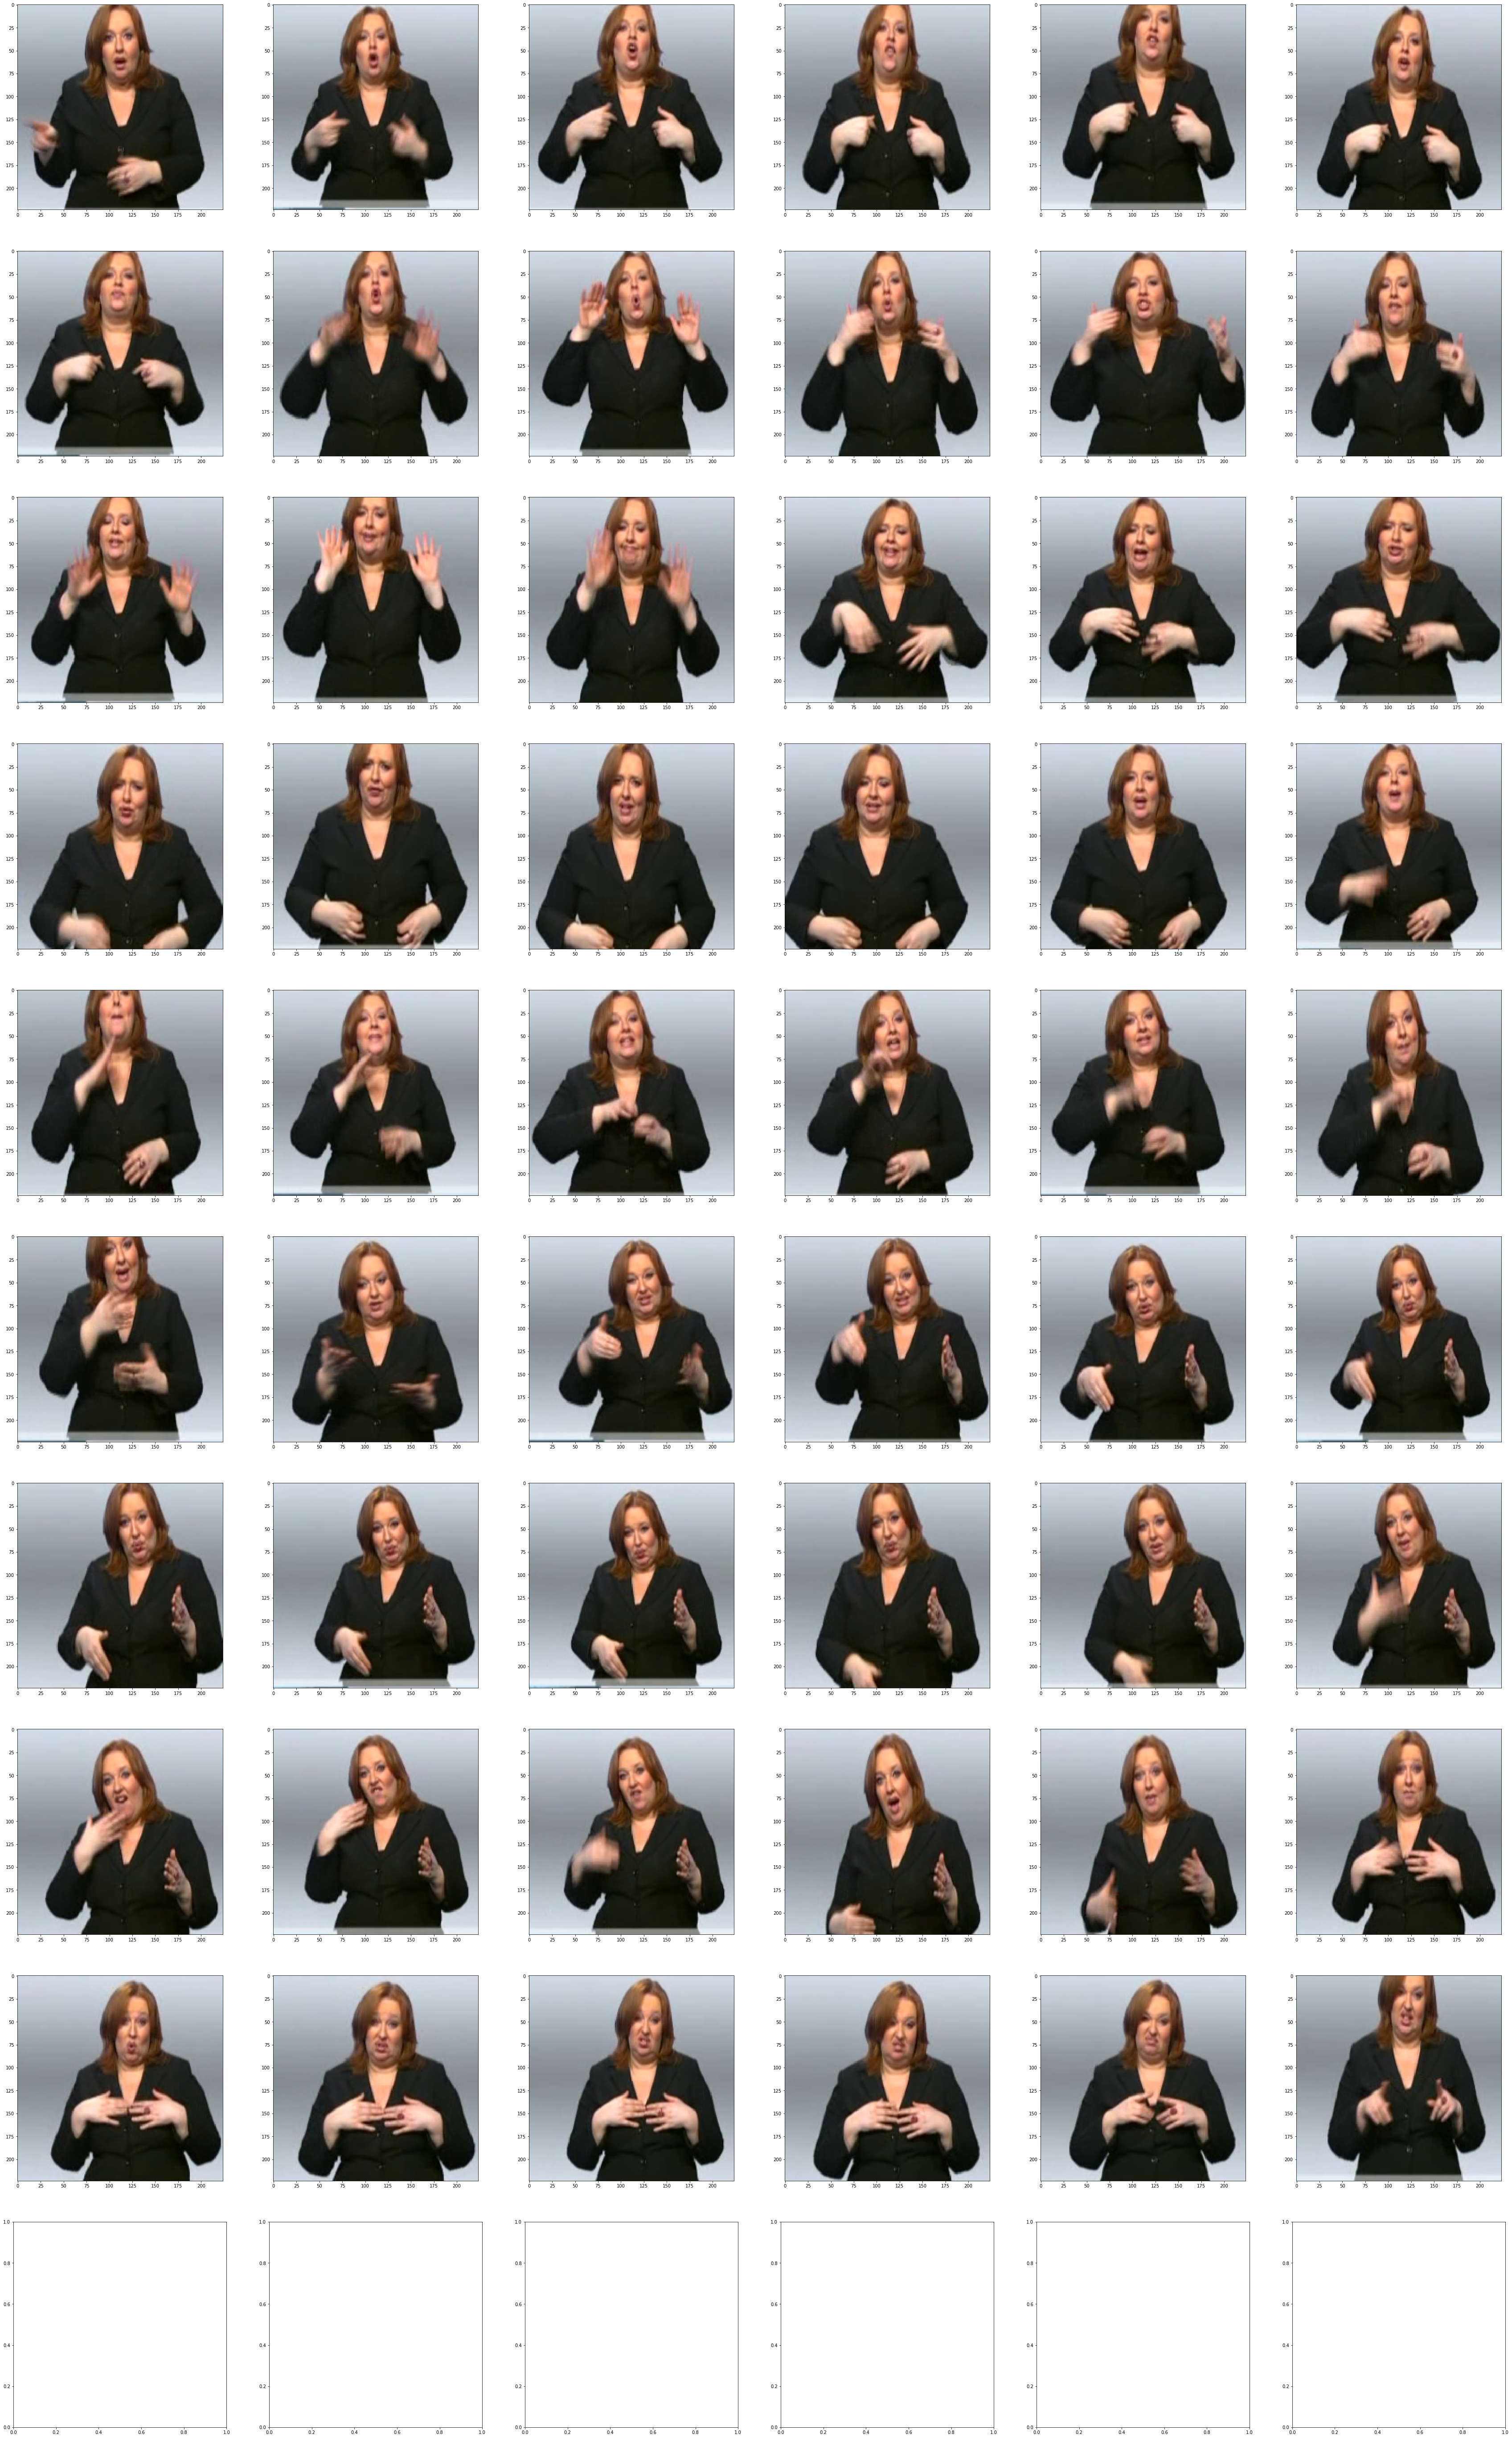

In [3]:
# for batch_idx, batch in enumerate(dev_loader):
#     if batch_idx ==0:
#         full = batch['fullVideos'].permute(0,1,3,4,2)
#         hand = batch['trackedHandVideos'].permute(0,1,3,4,2)
#         n,t,h,w,c = hand.size()
        
#         fig, ax = plt.subplots(10,6,figsize=(60,100))
#         for i in range(t):
#             ax[i//6][i%6].imshow(full[0,i])
#         plt.show()
#         break

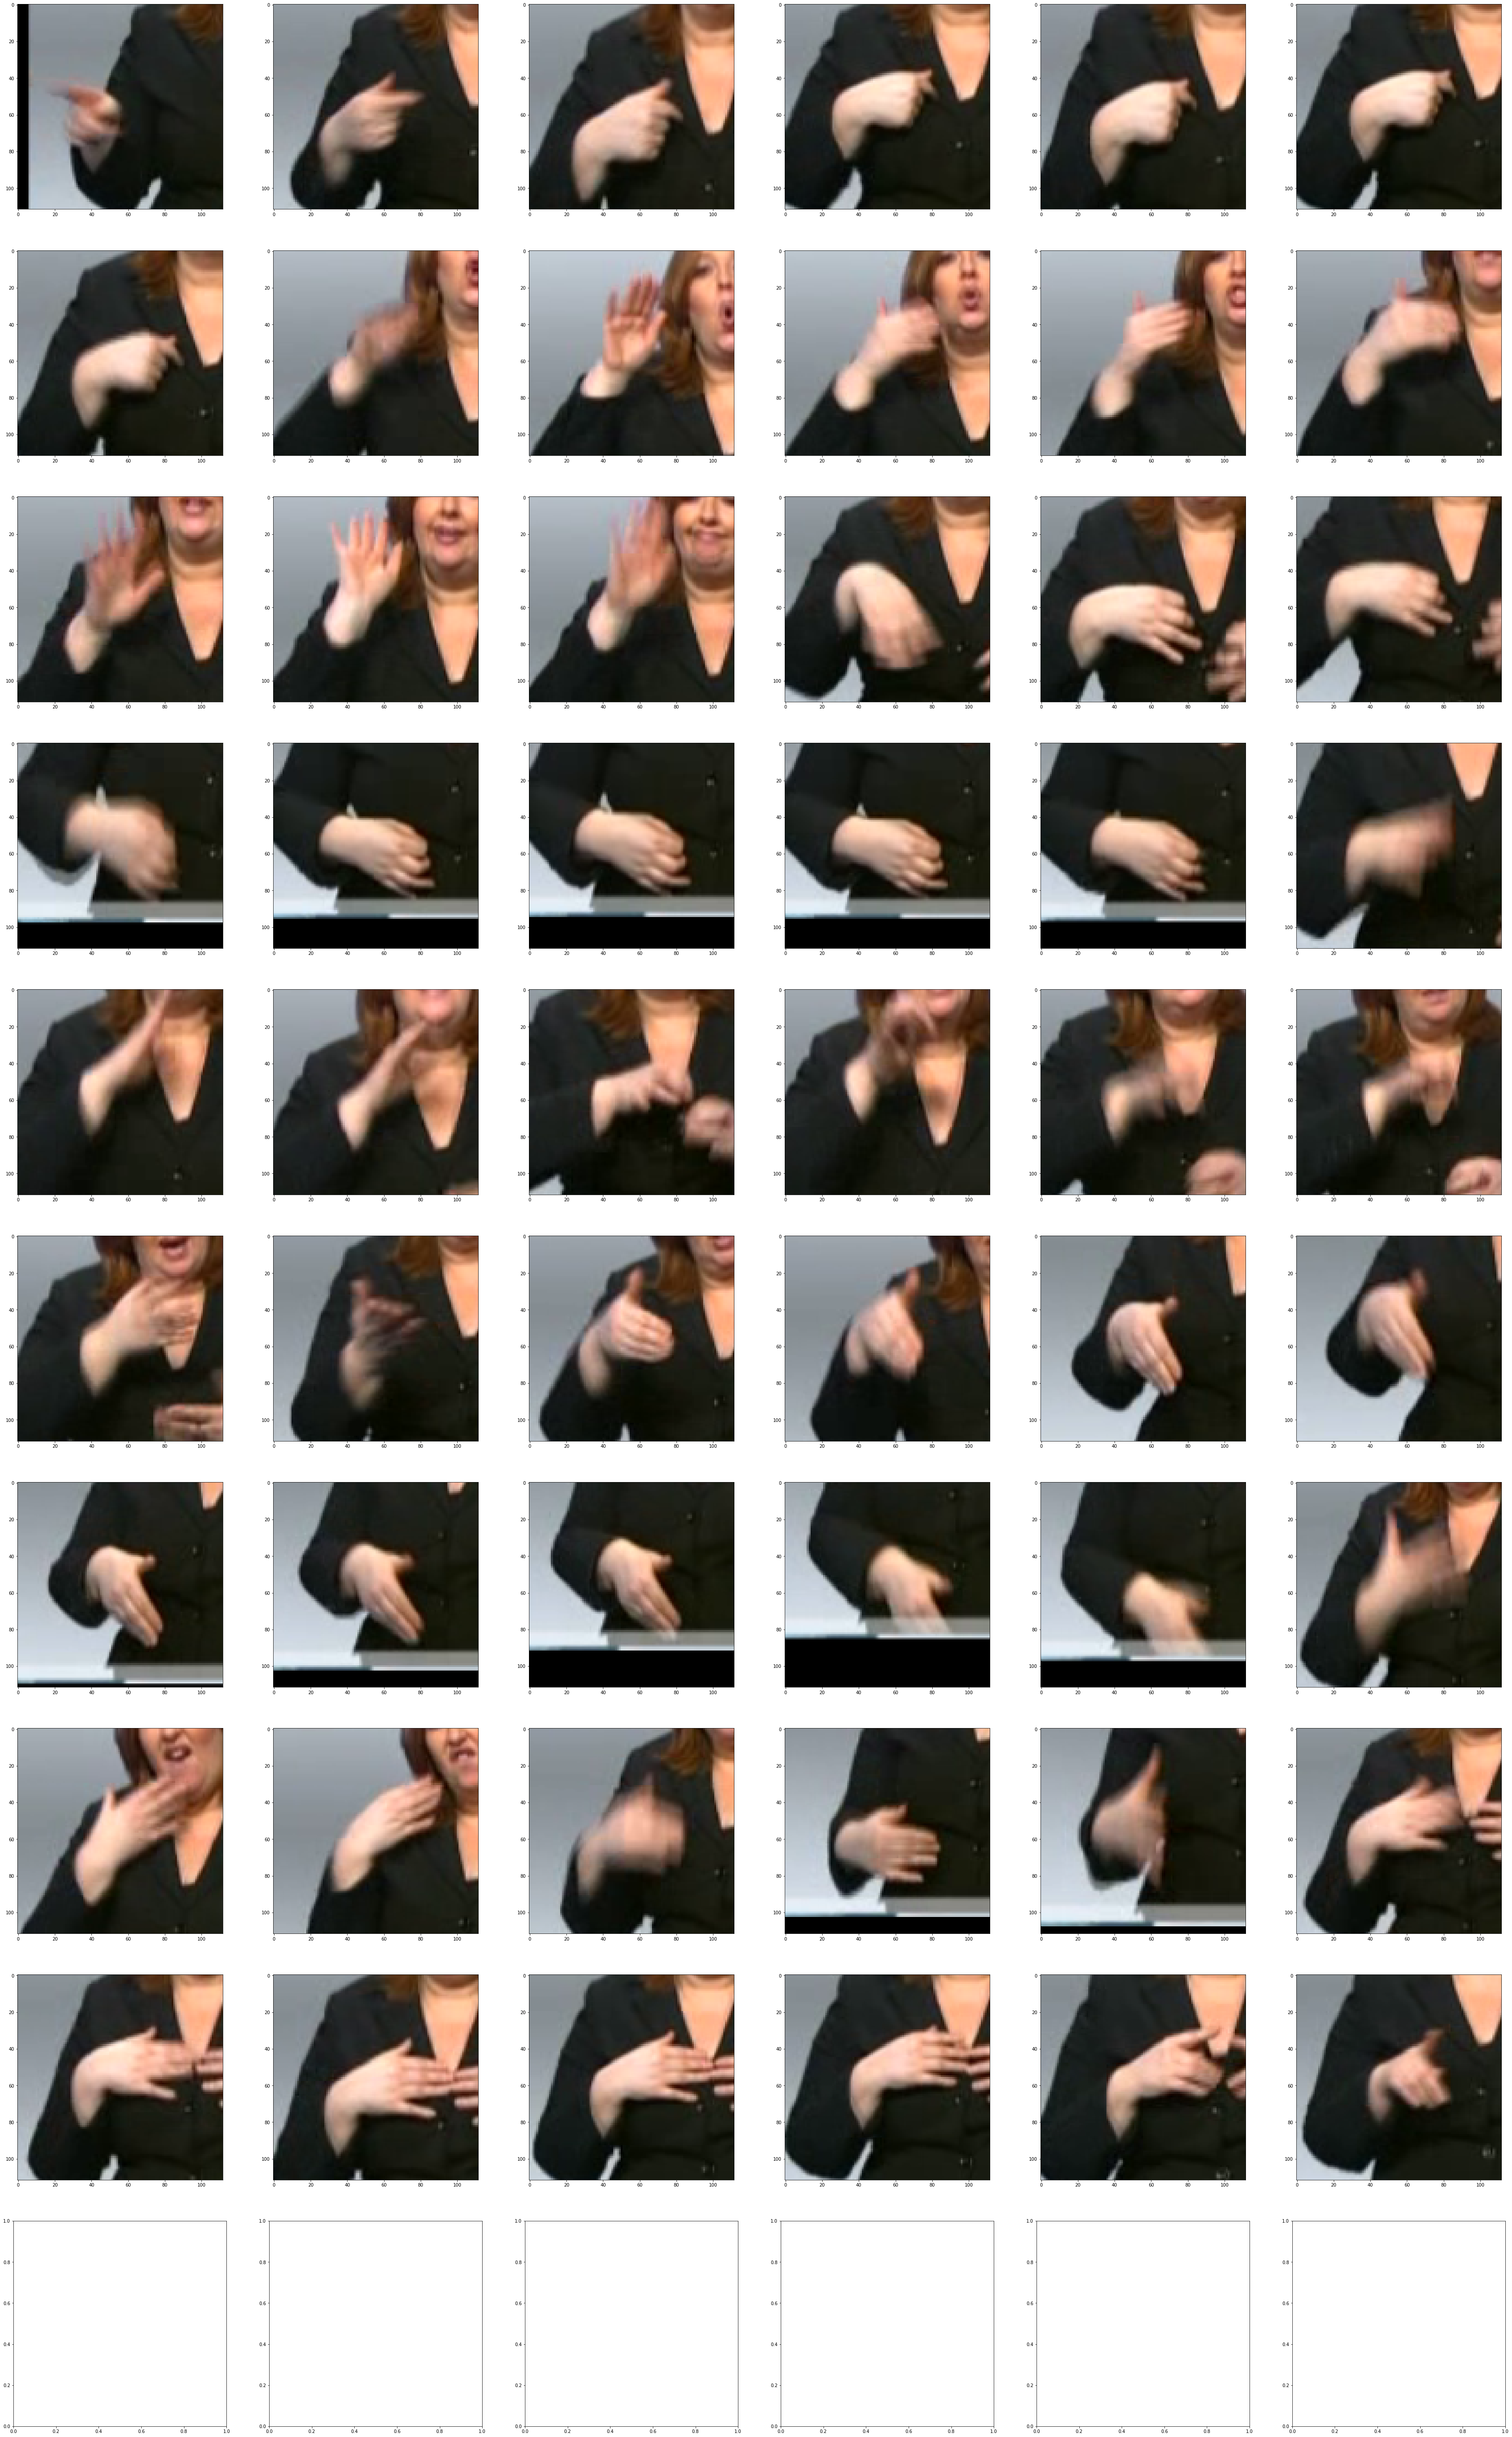

In [4]:
# for batch_idx, batch in enumerate(dev_loader):
#     if batch_idx ==0:
#         full = batch['fullVideos'].permute(0,1,3,4,2)
#         hand = batch['trackedHandVideos'].permute(0,1,3,4,2)
#         n,t,h,w,c = hand.size()
        
#         fig, ax = plt.subplots(10,6,figsize=(60,100))
#         for i in range(t):
#             ax[i//6][i%6].imshow(hand[0,i])
#         plt.show()
#         break

some trick:
    时间复杂度：输入：2*180*3*224*224， num_worker=10, pin_memory=true, 0<gpu_utils<1
    空间复杂的：输入: 2*180*3*224*224, 6000~7000, 看序列长度
    训练第一个epoch前面loss下降后面出现NaN（梯度爆炸？）
        1） lr从1e-4 -> 1e-6 学习速度太慢，loss下降后基本不变，仍然出现cnn第一层conv出现NaN
        2） 梯度裁剪: 仍然出现grad NaN(feature.0.weight正常)
        3)  参数初始化：仍然出现NaN
        4） 使用GN: 仍然出现NaN
        5) 神经网络层数(减小一层GRU层): grad仍然出现NaN，发现是一个样本导致NaN。但是loss没有再出现NaN
        6) 某一个batch导致梯度爆炸，从而导致参数出现NaN，进而lossNaN, 为什么这个batch会导致梯度爆炸（参数累计的原因还是样本的原因）？
    过拟合（train wer 0.2674, val wer:0.6; train loss: 1.066, wer loss: 3.34）？
        1) assert后没有训练后面的数据，导致数据集减少
        2）先在小数据集上找到最优的时间复杂度，空间复杂度，结果（样本规模：1->测试集->训练集）
        3) 数据集增强（无明显效果，训练集和测试集差异不大）
        4) ImageNet与手语相差大导致过拟合，使用参数初始化代替预训练模型
        5) lr schedule
        6) weight decay
        7) 使用ResNet代替AlexNet （wer：0.6->0.4）
    一些调试方法
        1) 使用一个样本快速看算法是否有问题
        2）使用shuffle=False检查数据集是否有问题
        3）小样本集（测试集作为训练集）找超参数
        4) 增加网络层数可以提升精度，前提要防止梯度爆炸和梯度消失，过拟合
    导入数据太慢：
        1）num_worker与batch_size（注意不是视频帧数）最好1:1
        2) 当batch为视频时，一个batch内使用多线程读取frames
    收敛速度：
        1）预训练模型可以加快收敛
        2）即使只训练一个样本，当模型很大时，从零训练起也很难训练
        3）输入长度变为1/2，相比原长度加快收敛（减少学习一些不必要的冗余）
        4）输入长度变为1/4，收敛最快，loss最低
        5) 输入长度变为1/6， 收敛速度最快，loss最低
    继续训练：
        1）导入模型
        2）更改起始epoch
        3）更改best_wer
    速度太慢：
        1）I/O
        2）网络延迟，使用python脚本代替jupyter notebook
        3) 重新启动